# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

In [2]:
!pip install evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.4 MB/s eta 0:00:00


In [3]:
# imports
import torch
from datasets import load_dataset
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.transforms import functional as F
from transformers import Trainer, TrainingArguments
import evaluate
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator

# Load Dataset

In [4]:
ds = load_dataset("microsoft/cats_vs_dogs")
ds

README.md:   0%|          | 0.00/8.16k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/330M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/391M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/23410 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 23410
    })
})

In [5]:
dataset = ds['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 18728
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 4682
    })
})

In [6]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=235x313>,
 'labels': 0}

# Original Processor and Model

In [7]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

# Display Image

In [8]:
mean = [0.485, 0.456, 0.406]  # Mean used for normalization
std = [0.229, 0.224, 0.225]   # Std deviation used for normalization

def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean


In [9]:
def display_image(image, figsize=(10, 10)):
    grid_image = make_grid(image)
    if not isinstance(grid_image, list):
        grid_image = [grid_image]
    fix, axs = plt.subplots(ncols=len(grid_image), squeeze=False, figsize=figsize)
    for i, img in enumerate(grid_image):
        img = img.detach()
        img = denormalize(img, mean, std)
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

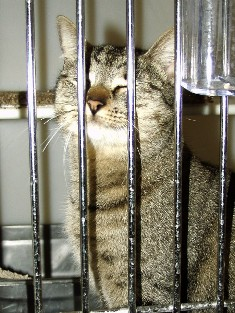

In [10]:
sample_image = dataset['train'][0]['image']
sample_image

# Preview Original Model

In [11]:
inputs = processor(sample_image, return_tensors="pt")

In [12]:
with torch.no_grad():
    logits = model(**inputs).logits

In [13]:
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

guenon, guenon monkey


# Image Augmentation

In [14]:
size = (
    processor.size["shortest_edge"]
    if "shortest_edge" in processor.size
    else (processor.size["height"], processor.size["width"])
)
normalize = transforms.Normalize(mean=processor.image_mean, std=processor.image_std)

_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    # transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.5, hue=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.ToTensor(),
    normalize,
])

In [15]:
def transform_image(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

In [16]:
data_collator = DefaultDataCollator()

# Preprocess Dataset

In [17]:
processor

ConvNextImageProcessor {
  "crop_pct": 0.875,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "ConvNextImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "shortest_edge": 224
  }
}

In [18]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [19]:
label2id

{'cat': '0', 'dog': '1'}

In [20]:
dataset = dataset.with_transform(transform_image)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 18728
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 4682
    })
})

In [21]:
type(dataset)

datasets.dataset_dict.DatasetDict

# Visualize Preprocessed Image

In [22]:
import matplotlib.pyplot as plt

In [23]:
dataset['train'][0]

{'labels': 0,
 'pixel_values': tensor([[[-2.1179,  2.1633,  2.1804,  ..., -0.3198, -0.2684, -0.4397],
          [-2.1179,  2.2318,  2.1804,  ..., -0.5424, -0.2684, -0.3712],
          [-2.1179,  2.2147,  2.1804,  ..., -0.2342, -0.3198, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357,  2.4286,  2.4286,  ...,  0.3803,  0.4503,  0.2927],
          [-2.0357,  2.4286,  2.4286,  ...,  0.2052,  0.4503,  0.3452],
          [-2.0357,  2.4286,  2.4286,  ...,  0.5028,  0.3452, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044,  2.6400,  2.6400,  ...,  0.3742,  0.4614,  0.2696]

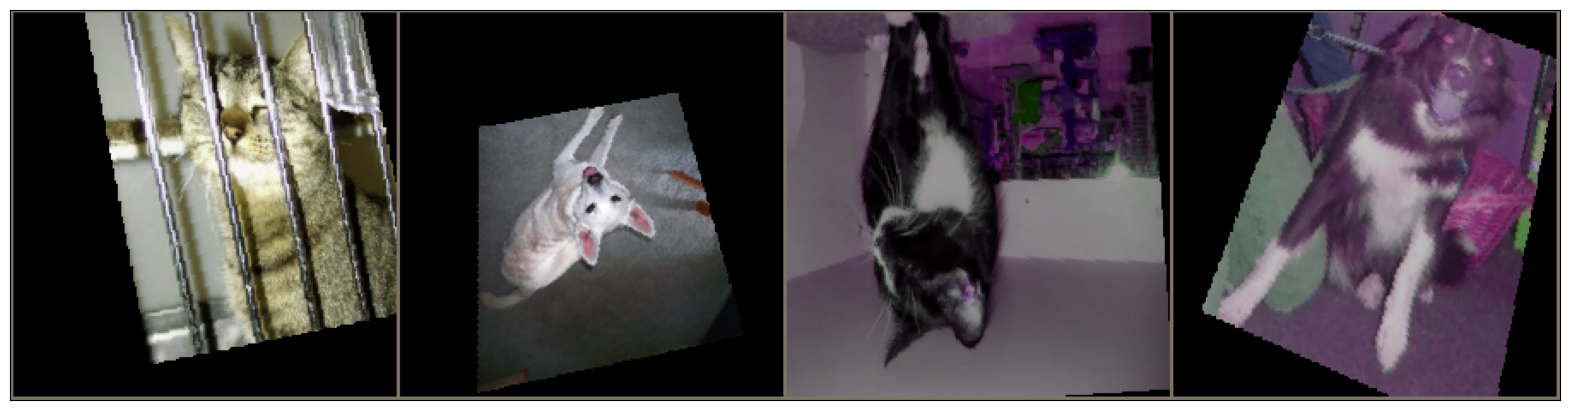

In [24]:
display_image(dataset['train'][:4]['pixel_values'], (20,20))

# Evaluator

# Load Model for Fine-tune

In [25]:
metric = evaluate.load("accuracy")

In [26]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [27]:
f_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50", 
                                                       num_labels=len(labels),
                                                       id2label=id2label,
                                                       label2id=label2id,
                                                       torch_dtype="auto", 
                                                       ignore_mismatched_sizes=True)

Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="cat_dog_classifier",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    num_train_epochs=5,
    # weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    metric_for_best_model="accuracy",
    report_to=['none']
)

# Define Trainer
trainer = Trainer(
    model=f_model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=processor,
    compute_metrics=compute_metrics,
)

In [29]:
help(Trainer.__init__)

Help on function __init__ in module transformers.trainer:

__init__(self, model: Union[transformers.modeling_utils.PreTrainedModel, torch.nn.modules.module.Module] = None, args: transformers.training_args.TrainingArguments = None, data_collator: Optional[transformers.data.data_collator.DataCollator] = None, train_dataset: Union[torch.utils.data.dataset.Dataset, torch.utils.data.dataset.IterableDataset, ForwardRef('datasets.Dataset'), NoneType] = None, eval_dataset: Union[torch.utils.data.dataset.Dataset, Dict[str, torch.utils.data.dataset.Dataset], ForwardRef('datasets.Dataset'), NoneType] = None, tokenizer: Optional[transformers.tokenization_utils_base.PreTrainedTokenizerBase] = None, model_init: Optional[Callable[[], transformers.modeling_utils.PreTrainedModel]] = None, compute_metrics: Optional[Callable[[transformers.trainer_utils.EvalPrediction], Dict]] = None, callbacks: Optional[List[transformers.trainer_callback.TrainerCallback]] = None, optimizers: Tuple[torch.optim.optimizer.O

# Train the model

In [30]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'labels'],
        num_rows: 18728
    })
    test: Dataset({
        features: ['image', 'labels'],
        num_rows: 4682
    })
})

In [31]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.187223,0.944041
2,0.332600,0.112049,0.958992
3,0.332600,0.087737,0.967749
4,0.118200,0.093969,0.964118
5,0.118200,0.088418,0.968817


TrainOutput(global_step=1465, training_loss=0.18557662703478295, metrics={'train_runtime': 1496.0254, 'train_samples_per_second': 62.593, 'train_steps_per_second': 0.979, 'total_flos': 1.9884831769829376e+18, 'train_loss': 0.18557662703478295, 'epoch': 5.0})

In [32]:
# trainer.save_model("mog_cat_dog")

In [33]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("huggingface_token")
trainer.push_to_hub(token=secret_value_0)

training_args.bin:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/MoGHenry/cat_dog_classifier/commit/82bb4688571d379396918dd792ec7b46ba6e5e3d', commit_message='End of training', commit_description='', oid='82bb4688571d379396918dd792ec7b46ba6e5e3d', pr_url=None, pr_revision=None, pr_num=None)

# Test

In [34]:
from transformers import pipeline
import matplotlib.pyplot as plt

In [35]:
test_sample = ds['train'][:4]['image'] + ds['train'][-4:]['image']
test_sample

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x281>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=489x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=403x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=350x262>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=331x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=97x150>]

In [36]:
pipe = pipeline("image-classification", model="MoGHenry/cat_dog_model")

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [37]:
predicted = pipe(test_sample)
predicted

[[{'label': 'cat', 'score': 0.9670462608337402},
  {'label': 'dog', 'score': 0.02912117727100849}],
 [{'label': 'cat', 'score': 0.8653389811515808},
  {'label': 'dog', 'score': 0.11778271943330765}],
 [{'label': 'cat', 'score': 0.9367992281913757},
  {'label': 'dog', 'score': 0.057894013822078705}],
 [{'label': 'cat', 'score': 0.9520422220230103},
  {'label': 'dog', 'score': 0.038546379655599594}],
 [{'label': 'dog', 'score': 0.946323812007904},
  {'label': 'cat', 'score': 0.05982666090130806}],
 [{'label': 'dog', 'score': 0.8369699120521545},
  {'label': 'cat', 'score': 0.1408551186323166}],
 [{'label': 'dog', 'score': 0.963063657283783},
  {'label': 'cat', 'score': 0.04124315455555916}],
 [{'label': 'dog', 'score': 0.9265713691711426},
  {'label': 'cat', 'score': 0.07078384608030319}]]

In [38]:
predicted_labels = [max(entry, key=lambda x: x['score'])['label'] for entry in predicted]
predicted_labels

['cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog']

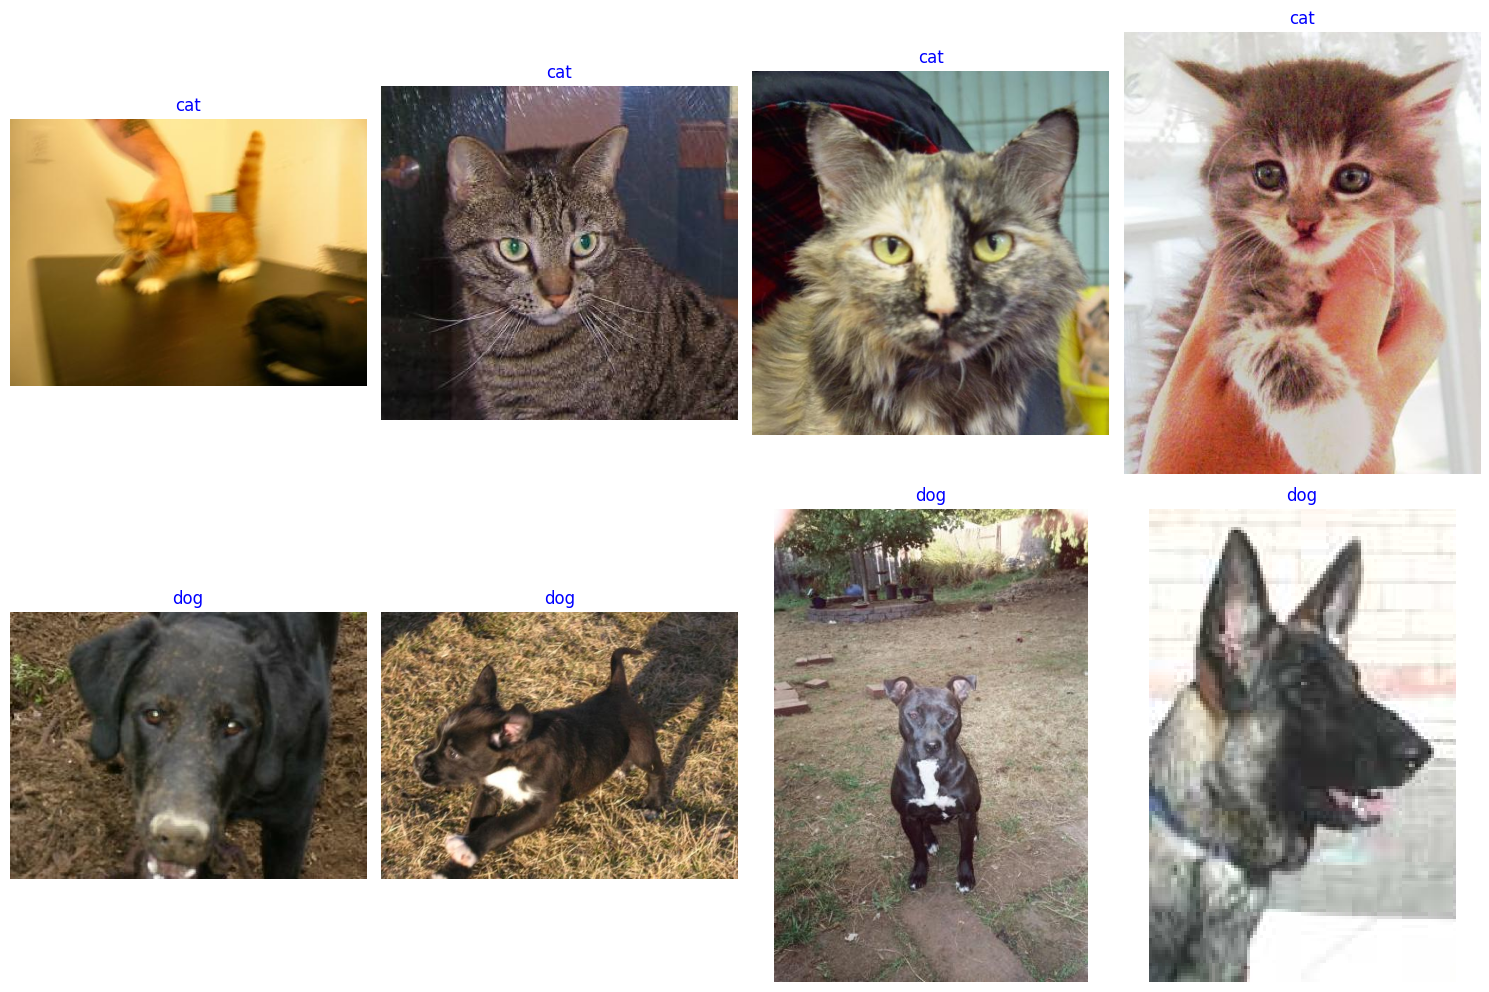

In [39]:
num_images_per_row = 4
num_rows = (len(test_sample) + num_images_per_row - 1) // num_images_per_row

fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(15, 5 * num_rows))

axes = axes.flatten()

for i, (image, label) in enumerate(zip(test_sample, predicted_labels)):
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide the axes
    axes[i].set_title(label, fontsize=12, color='blue')  # Add the label as the title

for i in range(len(test_sample), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()